Le cancer de la peau est l'un des cancers les plus fréquents chez l'humain. Il est généralement diagnostiqué visuellement à partir d'une première consultation clinique, suivie éventuellement d'une analyse dermoscopique, d'une biopsie, et d'un examen histopathologique. La classification automatisée des lésions cutanées à l'aide d'images est une tâche complexe en raison de la grande diversité dans l'apparence des lésions cutanées.

Dans ce notebook, nous utilisons le jeu de données HAM10000 ("Human Against Machine with 10,000 training images") pour entraîner un modèle d'apprentissage automatique. Ce jeu de données contient 10 015 images dermatoscopiques, disponibles publiquement via les archives de l'ISIC. Il sert de référence pour la recherche académique et permet de comparer les performances des modèles avec celles des experts humains.

Le jeu de données regroupe 7 classes différentes de cancers de la peau, listées ci-dessous :

**1. Melanocytic nevi <br>**
**2. Melanoma <br>**
**3. Benign keratosis-like lesions <br>**
**4. Basal cell carcinoma <br>**
**5. Actinic keratoses <br>**
**6. Vascular lesions <br>**
**7. Dermatofibroma<br>**
Dans ce notebook, nous allons construire un modèle basé sur un réseau de neurones convolutifs (Convolutional Neural Network - CNN) avec TensorFlow et Keras . L'objectif est de classifier les 7 classes de cancers de la peau et d'analyser les performances du modèle pour évaluer son utilité dans des scénarios pratiques.


# Plan de construction du modèle

Pour construire et évaluer notre modèle, nous allons suivre **14 étapes clés** décrites ci-dessous : <br>

1. **Importer les bibliothèques essentielles** <br>
   Importer toutes les bibliothèques nécessaires pour le traitement des données et la construction du modèle.  
   
2. **Créer un dictionnaire des images et des étiquettes** <br>
   Associer chaque image de notre jeu de données à sa classe.  

3. **Lire et traiter les données** <br>
   Charger les données et effectuer les pré-traitements requis.  

4. **Nettoyage des données** <br>
   Gérer les valeurs manquantes, les doublons, ou tout autre problème dans le jeu de données.  

5. **Analyse exploratoire des données (EDA)** <br>
   Explorer le jeu de données à l'aide de visualisations et de statistiques pour comprendre sa structure et ses caractéristiques.  

6. **Chargement et redimensionnement des images** <br>
   Charger les images et les redimensionner à une taille uniforme pour le modèle.  

7. **Division des données en ensembles d'entraînement et de test** <br>
   Séparer les données pour garantir une évaluation juste de notre modèle.  

8. **Normalisation des données** <br>
   Normaliser les pixels des images pour optimiser l'entraînement du modèle.  

9. **Encodage des étiquettes** <br>
   Convertir les étiquettes textuelles en valeurs numériques.  

10. **Division des données en ensembles d'entraînement et de validation** <br>
    Garder une partie des données d'entraînement pour valider les performances pendant l'entraînement.  

11. **Construction du modèle (CNN)** <br>
    Définir l'architecture du réseau de neurones convolutifs.  

12. **Paramétrage de l'optimiseur et ajustement du taux d'apprentissage** <br>
    Configurer l'optimiseur et ajuster dynamiquement le taux d'apprentissage.  

13. **Entraîner le modèle** <br>
    Faire passer les données dans le modèle pour ajuster les paramètres.  

14. **Évaluation du modèle** <br>
    Tester le modèle sur les données de test, analyser la matrice de confusion et les erreurs de classification.  


## Etape 1 : **Importer les bibliothèques essentielles**

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(1)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization

from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

## Étape 2 : Création d'un dictionnaire des chemins d'images et des étiquettes
Dans cette étape, nous allons créer un dictionnaire qui associe les noms des fichiers d'image à leurs chemins complets. Les images sont situées dans deux dossiers différents (HAM10000_images_part1.zip et HAM10000_images_part2.zip), que nous allons fusionner dans un répertoire de base appelé base_skin_dir. Les images sont au format .jpg.

In [14]:
base_skin_dir = os.path.join('..', 'input')


imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/', '*', '*.jpg'))}


lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [15]:
# imageid_path_dict

## Étape 3 : Lecture et traitement des données  

Dans cette étape, nous avons :  
1. Lu le fichier CSV contenant les métadonnées des images.  
2. Ajouté une colonne **`path`** associant chaque image à son chemin complet.  
3. Créé des colonnes supplémentaires pour une compréhension plus facile :  
   - **`cell_type`** : Nom simplifié du type de lésion.  
   - **`cell_type_idx`** : Code numérique (0 à 6) représentant chaque type de lésion

In [16]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [17]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


## Étape  4 : Data Cleaning

In [18]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
#remplacer les valeurs nulls par le moyenne
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

## Étape 5: Chargement et redimensionnement des images  

Dans cette étape, nous avons chargé les images à partir des chemins spécifiés dans la colonne **`path`** et les avons redimensionnées. Les dimensions originales des images sont de **450 x 600 x 3**, ce qui est trop grand pour être directement traité par TensorFlow. Nous avons donc redimensionné toutes les images à **100 x 75** pour optimiser leur utilisation dans le modèle.  


In [20]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

<Axes: xlabel='cell_type'>

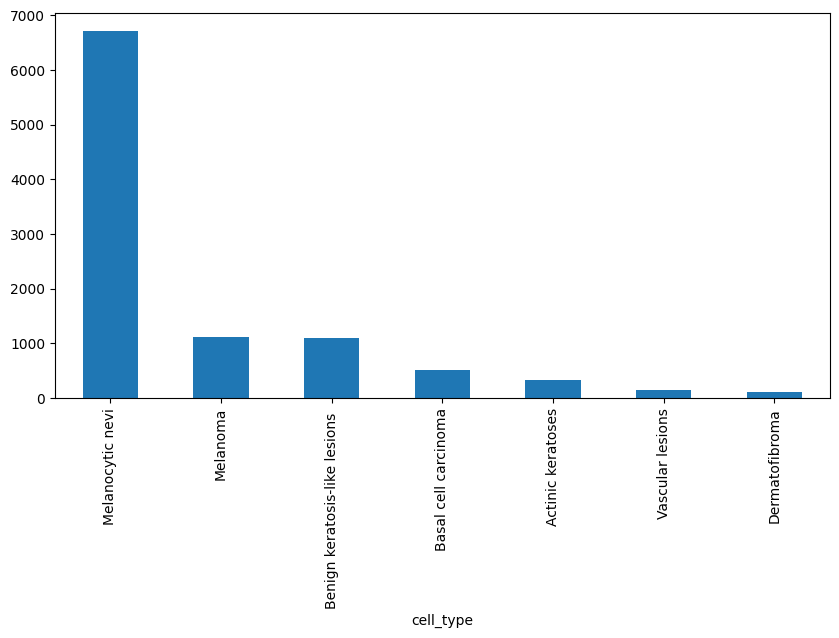

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [22]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


Afficher des échantillons d'images pour chaque type de cancer de la peau

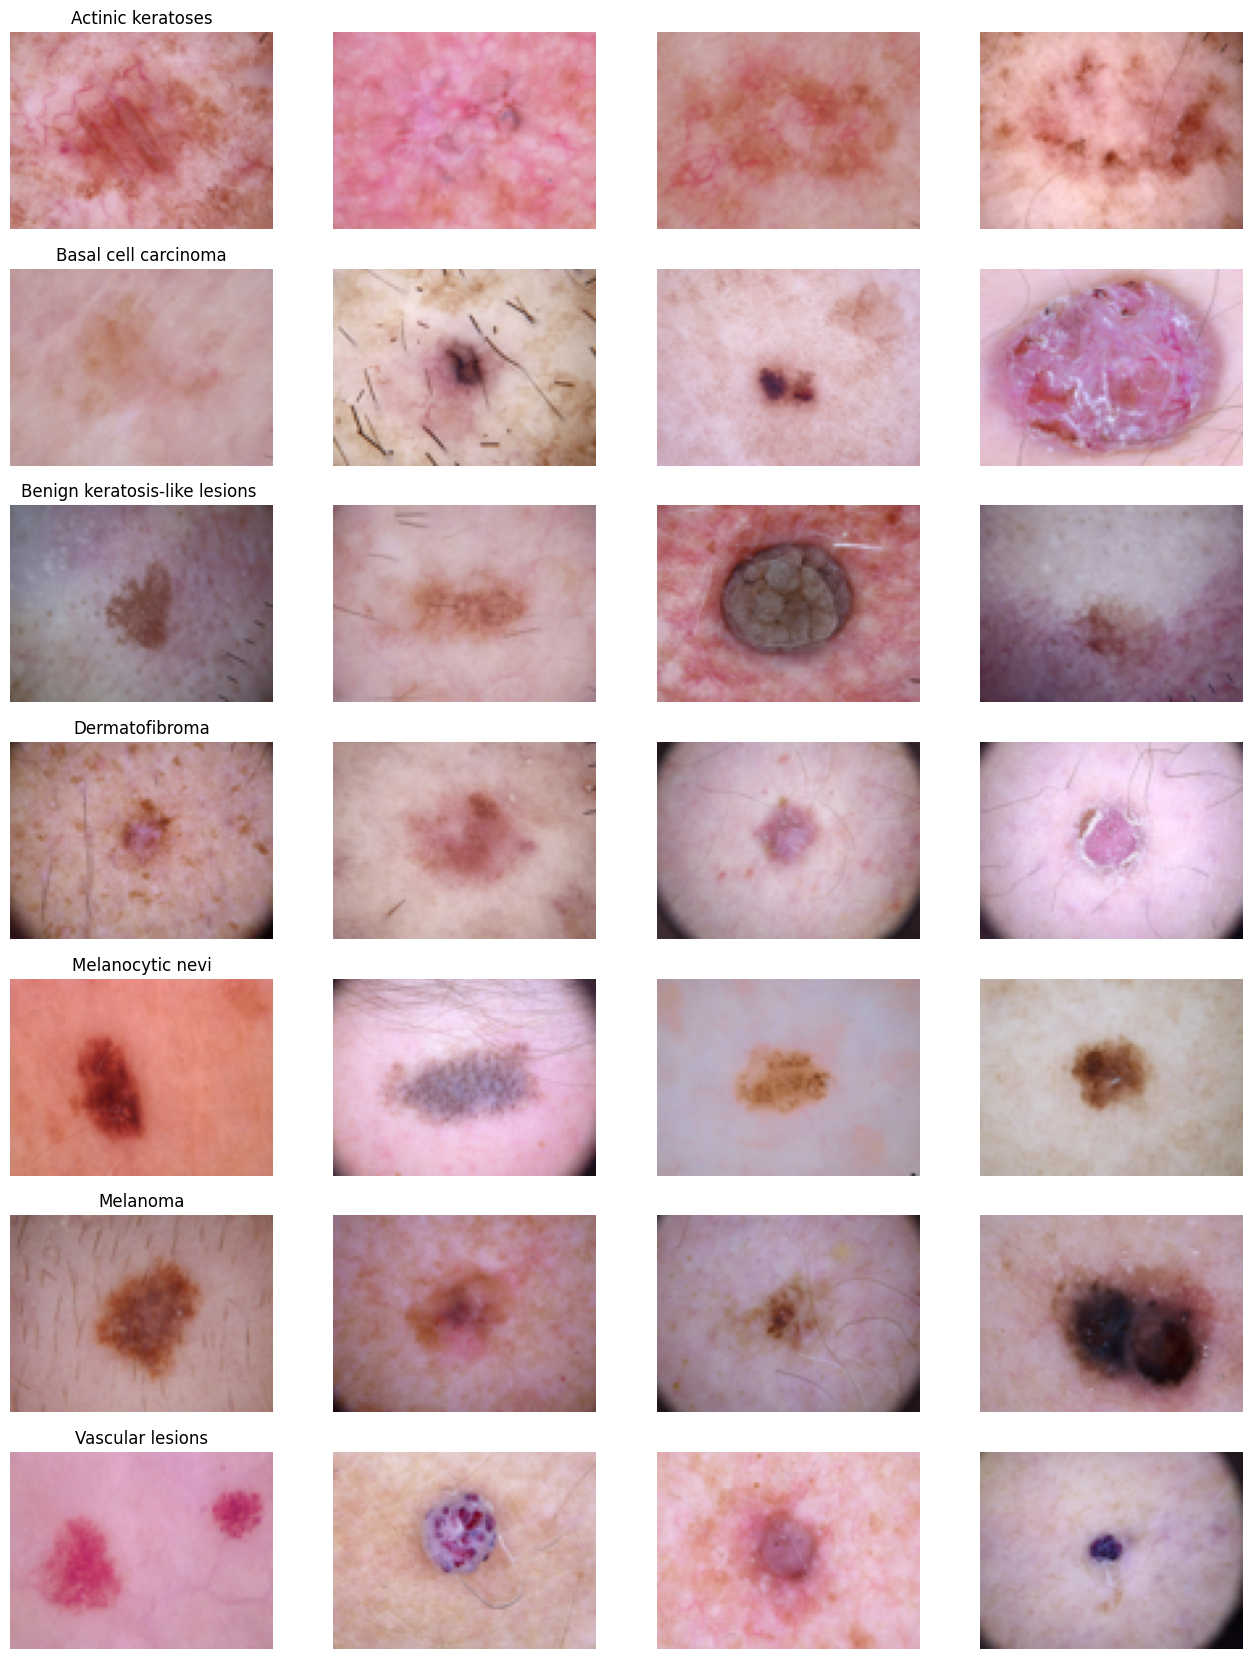

In [23]:
n_samples = 4
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [56]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [55]:
target.shape

(10015,)

In [25]:
from sklearn.model_selection import train_test_split

## Étape 6 : Train Test Split

Dans cette étape, nous avons divisé notre jeu de données en deux parties : un ensemble d'entraînement et un ensemble de test. Nous avons choisi un ratio de 80:20, ce qui signifie que 80 % des données seront utilisées pour entraîner notre modèle et 20 % seront utilisées pour tester sa performance.

In [79]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=124)

In [80]:
x_train_o.shape

(8012, 10)

## Étape 7 :Normalisation et Label Encoding

In [81]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [82]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [83]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [84]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## Étape 8 : Model Building (CNN)

Dans cette étape, nous avons construit un modèle de réseau neuronal convolutif (CNN) en utilisant l'API séquentielle de Keras. Voici un aperçu de l'architecture CNN utilisée pour la classification des images de lésions cutanées :

1. **Convolutional Layers** : Ces couches utilisent des filtres pour détecter des caractéristiques importantes dans l'image.
2. **Pooling Layers** : Ces couches réduisent la taille des cartes de caractéristiques tout en conservant les informations essentielles.
3. **Dropout** : Une technique de régularisation pour éviter le surapprentissage.
4. **Flatten** : Cette couche aplatit les cartes de caractéristiques pour les rendre compatibles avec les couches entièrement connectées.
5. **Dense Layers** : Ces couches servent à classer les caractéristiques extraites en fonction des classes assification.



In [140]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

## Étape 9 : Définition de l'Optimiseur et de l'Annealing

Une fois que les couches ont été ajoutées au modèle, nous devons définir une fonction de score, une fonction de perte et un algorithme d'optimisation.

Nous définissons la fonction de perte pour mesurer la mauvaise performance de notre modèle sur les images avec des étiquettes connues. Il s'agit du taux d'erreur entre les étiquettes observées et les étiquettes prédites. Pour les classifications catégorielles (plus de 2 classes), nous utilisons une forme spécifique appelée **"categorical_crossentropy"**.

La fonction la plus importante est l'optimiseur. Cette fonction va améliorer de manière itérative les paramètres du modèle (valeurs des filtres, noyaux, poids et biais des neurones, etc.) afin de minimiser la perte.

J'ai choisi l'optimiseur **Adam** car il combine les avantages de deux autres extensions de la descente de gradient stochastique. Plus précisément :

1. **AdaGrad** (Adaptive Gradient Algorithm) qui maintient un taux d'apprentissage par paramètre qui améliore les performances sur les problèmes avec des gradients rares (par exemple, les problèmes de traitement du langage naturel et de vision par ordinateur).
   
2. **RMSProp** (Root Mean Square Propagation) qui maintient également des taux d'apprentissage par paramètre adaptés en fonction de la moyenne des magnitudes récentes des gradients pour chaque poids (par exemple, la rapidité avec laquelle il change). Cela permet à l'algorithme de bien fonctionner sur des problèmes en ligne et non stationnaires (par exemple, bruyants).

**Adam** réalise les avantages de **AdaGrad** et **RMSProp**.

Adam est un algorithme populaire dans le domaine de l'apprentissage profond car il donne de bons résultats rapidement.

La fonction de métrique **"accuracy"** est utilisée pour évaluer les performances de notre modèle. Cette fonction de métrique est similaire à la fonction de perte, sauf que les résultats de l'évaluation de la métrique ne sont pas utilisés lors de l'entraînement du modèle (uniquement pour l'évaluation).


In [141]:
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [142]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

## Étape 10 : Entraînement du modèle

Dans cette étape, nous allons enfin entraîner le modèle en utilisant les données d'entraînement `x_train` et `y_train`. J'ai choisi une taille de lot (**batch size**) de 10 et un nombre de **50 epochs**.

- **Taille de lot (batch size)** : Plus la taille du lot est petite, plus le modèle sera formé de manière plus efficace. Cela permet au modèle d'apprendre de manière plus précise à chaque itération.
  
- **Epochs** : J'ai sélectionné 50 epochs pour donner au modèle suffisamment de cycles d'apprentissage pour s'ajuster correctement aux données et éviter sous-apprentissage ou sur-apprentissage.

Ce processus d'entraînement permettra au modèle d'apprendre les patterns des images et des étiquettes associées à ces images afin de prédire correctement les types de lésions cutanées lors de l'évaluation.


In [144]:
epochs = 30 
batch_size = 10
history = model.fit(
    x_train, 
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_validate, y_validate),
    verbose=1,
    callbacks=[learning_rate_reduction]
)


Epoch 1/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6589 - loss: 1.0701 - val_accuracy: 0.6746 - val_loss: 0.8821 - learning_rate: 0.0010
Epoch 2/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6742 - loss: 0.9011 - val_accuracy: 0.6945 - val_loss: 0.8467 - learning_rate: 0.0010
Epoch 3/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7000 - loss: 0.8466 - val_accuracy: 0.6908 - val_loss: 0.9016 - learning_rate: 0.0010
Epoch 4/30
715/721 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7013 - loss: 0.8481
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7014 - loss: 0.8479 - val_accuracy: 0.7095 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 5/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7303 - loss: 0.7438 - val_accuracy: 0.7344 - val_loss: 0.7197 - learning_rate: 5.0000e-04
Epoch 6/30
721/721 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7489 - loss: 0.690

In [145]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7448 - loss: 0.9084
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7602 - loss: 0.8430
Validation: accuracy = 0.756858  ;  loss_v = 0.858676
Test: accuracy = 0.737394  ;  loss = 0.967793
